In [2]:
import os, glob
import numpy as np

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import Rank2D
from yellowbrick.features.pca import PCADecomposition

from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import h5py
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from GNN.utils.cm import plot_confusion_matrix
from GNN.utils.datautils import (
    get_data,
    balance_dataset,
    find_transition_regions
)

/cosma/local/Python/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
label = "dark_or_light"
sampling = "downsample"

# 1. Load combined features from SubFind & Sownak 

In [4]:
# arxiv:1905.08799 talks about this stellar mass cut on page 4 top right column
output_file = 'merged_dataframe.h5'                                          
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

train, test = get_data(data_path + output_file, label)
print(len(train.columns.values))
train.sample(n=3, random_state=1)

20


,M200_DMO,M200c,Rmax,R200c,Cnfw,Rhosnfw,Formation Time,Nmergers,MassPeak,vpeak,N_subhalos,VelDisp,Vmax,Spin,fsub_unbound,x_offset,x_dmo,y_dmo,z_dmo,labels
33967,3.222000e+11,3.222035e+11,0.025756,111.500549,9.541781,1.095388e+07,1.151545,1.0,5.354194e+11,158.870071,1.0,73.738907,132.469254,13.077200,0.007121,657.466485,265.680687,269.871812,199.033187,True
87515,1.594000e+11,1.594472e+11,0.015614,88.186943,16.635263,4.515792e+07,1.966384,1.0,2.638693e+11,116.536285,2.0,62.604664,114.830658,5.033566,0.008136,2196.179003,144.617547,260.009687,162.087938,True
14264,4.474000e+11,4.473788e+11,0.058838,124.389297,4.836464,2.172080e+06,1.044931,2.0,7.858822e+11,138.228745,9.0,74.484482,128.212570,10.046845,0.170153,1174.137065,42.755012,50.261793,204.619156,True


In [5]:
## Balance training set in the transition region                             
center_transition, end_transition = find_transition_regions(train)

train = balance_dataset(                                                     
    train, center_transition, end_transition, sampling
)

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [7]:
train_features = train.drop(columns="labels")                                
train_labels = train["labels"]

test_features = test.drop(columns="labels")                                
test_labels = test["labels"]

feature_names = train_features.columns.values

In [8]:
## Standarize features                                                       
scaler = StandardScaler()
scaler.fit(train_features.values)
train_features_std = scaler.transform(train_features.values)
test_features_std = scaler.transform(test_features.values)

train_labels = train_labels.values
test_labels = test_labels.values

# !!!
# notice that features and labels are np.ndarrays now
# !!!

# 2 Feature Importance

## 2.0 PCA decomposition

In [9]:
def pca_transform(train, test, arg_pca):
    """
    """
    
    if isinstance(arg_pca, (dict)):
        return _pca_dict(train, test, arg_pca)
    elif isinstance(arg_pca, (float)):
        return _pca_corrlimit(train, test, arg_pca)
    elif arg_pca == "cross_val":
        return _pca_cross_val(train, test)


def _pca_dict(train, test, arg_pca: dict):
    """
    """
    pca = PCA(**arg_pca)

    # Perform feature optimization
    train = pca.fit_transform(train)
    test = pca.transform(test)

    return train, test, pca.n_components_


def _pca_corrlimit(train, test, correlation_limit: float):
    """
    """
    # convert np.ndarray to pd.dataframe
    if isinstance(train_features_std, (np.ndarray)):
        df_train = pd.DataFrame(
            data=train,
            index=np.arange(train.shape[0]),
            columns=["orig_%d" % ff for ff in range(train.shape[1])],
        )
        
        df_test = pd.DataFrame(
            data=test,
            index=np.arange(test.shape[0]),
            columns=["orig_%d" % ff for ff in range(test.shape[1])],
        )
    
    # Create correlation matrix
    corr_matrix = df_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than correlation_limit
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_limit)]
    # remove highly correlated features from dataset
    df_train = df_train.drop(df_train[to_drop], axis=1)
    df_test = df_test.drop(df_test[to_drop], axis=1)
    
    pca = PCA(n_components=len(df_train.columns.values))
    
    # Perform feature optimization
    train = pca.fit_transform(df_train.values)
    test = pca.transform(df_test.values)
    
    return train, test, pca.n_components


def _pca_cross_val(train, test):
    """
    """
    pca = PCA(svd_solver='full')

    pca_scores = []
    n_components = np.arange(0, train.shape[1], 1)

    # determine cross-val. score for different dimensions of feature space
    for n in n_components:
        pca.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, train, cv=5)))

    # choose # of dimensions with highest cross-val. score
    # another option would be: pca = PCA(svd_solver='full', n_components='mle')
    n_components = n_components[np.argmax(pca_scores)]
    pca.n_components = n_components
    
    # Perform feature optimization
    train = pca.fit_transform(train)
    test = pca.transform(test)

    return train, test, pca.n_components


print("Original feature space dimensions = %d" % train_features_std.shape[1])

arg_pca = {'n_components': 'mle', 'random_state': 0}
train_features_pca_mle, test_features_pca_mle, n_compontent_mle = pca_transform(
    train_features_std, test_features_std, arg_pca,
)
train_features_pca_corrlimit, test_features_pca_corrlimit, n_compontent_corrlimit = pca_transform(
    train_features_std, test_features_std, 0.95,
)
train_features_pca_cvs, test_features_pca_cvs, n_compontent_cvs = pca_transform(
    train_features_std, test_features_std, 'cross_val',
)
print("PCA dimensions for: \n corrlimit = %d\n cross_val = %d\n mle = %d" %
      (n_compontent_corrlimit, n_compontent_cvs, n_compontent_mle))

Original feature space dimensions = 19
PCA dimensions for: 
 corrlimit = 14
 cross_val = 18
 mle = 18


## 2.1 Pearson correlation score

### Before PCA

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


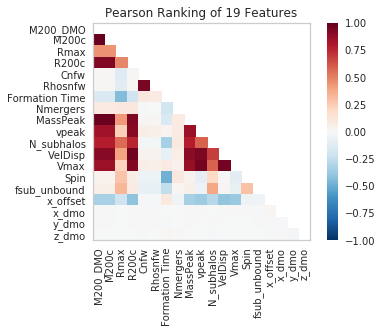

In [10]:
visualizer = Rank2D(features=feature_names, algorithm='pearson')

visualizer.fit(train_features_std, test_labels)
visualizer.transform(train_features_std)  
visualizer.poof()  

### After PCA - correlation limit

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


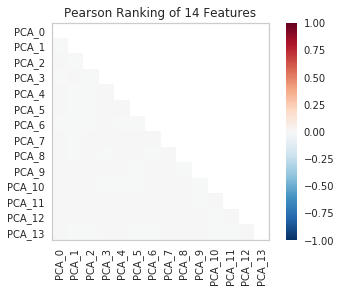

In [11]:
visualizer = Rank2D(
    features=['PCA_%d' % dd for dd in range(train_features_pca_corrlimit.shape[1])],
    algorithm='pearson',
)

visualizer.fit(train_features_pca_corrlimit, train_labels)
visualizer.transform(train_features_pca_corrlimit)  
visualizer.poof()

### After PCA - cross val. score

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


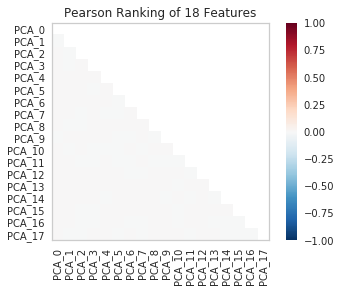

In [12]:
visualizer = Rank2D(
    features=['PCA_%d' % dd for dd in range(train_features_pca_cvs.shape[1])],
    algorithm='pearson',
)

visualizer.fit(train_features_pca_cvs, train_labels)
visualizer.transform(train_features_pca_cvs)  
visualizer.poof()

### After PCA - mle / Automatic Choice of Dimensionality by Thomas P. Minka

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


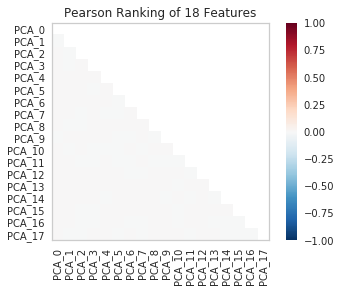

In [13]:
visualizer = Rank2D(
    features=['PCA_%d' % dd for dd in range(train_features_pca_mle.shape[1])],
    algorithm='pearson',
)

visualizer.fit(train_features_pca_mle, train_labels)
visualizer.transform(train_features_pca_mle)  
visualizer.poof()

## 2.2 PCA - Cumulative explained variance ratio

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


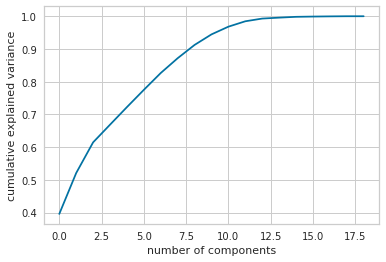

In [14]:
pca = PCA().fit(train_features_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# 3 RNF & Confusion matrix test

In [15]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)

## 3.0 Original

Normalized confusion matrix


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(array([[0.79365646, 0.20634354],
        [0.1602103 , 0.8397897 ]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8d31bbf98>)

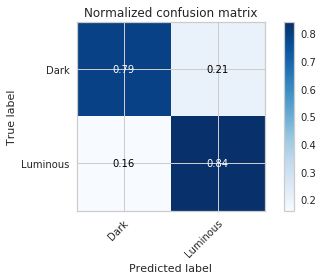

In [16]:
rf.fit(train_features_std, train_labels)
test_pred = rf.predict(test_features_std)

plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

## 3.1 correlation limit

Normalized confusion matrix


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(array([[0.81926635, 0.18073365],
        [0.15882423, 0.84117577]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8d30f3048>)

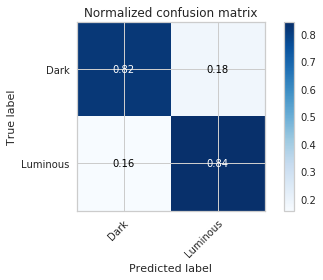

In [17]:
rf.fit(train_features_pca_corrlimit, train_labels)
test_pred = rf.predict(test_features_pca_corrlimit)

plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

## 3.1 cross val. score

Normalized confusion matrix


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(array([[0.81437297, 0.18562703],
        [0.14231091, 0.85768909]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8d30ee470>)

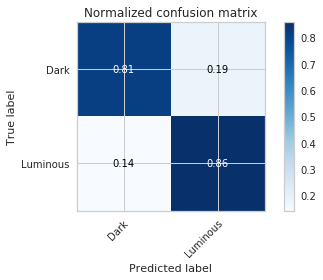

In [18]:
rf.fit(train_features_pca_cvs, train_labels)
test_pred = rf.predict(test_features_pca_cvs)

plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

## 3.1 mle

Normalized confusion matrix


/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(array([[0.81437297, 0.18562703],
        [0.14231091, 0.85768909]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8d30fca90>)

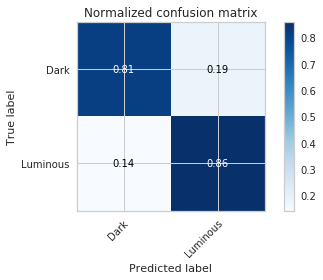

In [19]:
rf.fit(train_features_pca_mle, train_labels)
test_pred = rf.predict(test_features_pca_mle)

plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

## -.0 PCA - variance ratios in scaled dataset

In [20]:
scaler = StandardScaler()

scaler_data = scaler.fit_transform(df_subf)
pca = PCA().fit(scaler_data)

# Plot
fig, ax1 = plt.subplots()

# Axis 1
ax1.semilogy(
    pca.explained_variance_ratio_,
    '--bo',
    label='explained variance ratio',
)
color =  ax1.lines[0].get_color()
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_xlabel('principal component')
plt.legend(loc=(0.01, 0.075))

# Axis 2
ax2 = ax1.twinx()
ax2.semilogy(
    pca.explained_variance_ratio_.cumsum(),
    '--go',
    label='cumulative explained variance ratio',
)
for tl in ax2.get_yticklabels():
    tl.set_color('g')

plt.legend(loc=(0.01, 0))

NameError: name 'df_subf' is not defined

## -.1 PCA - inverse & biases

In [ ]:
n_comp = 7
pca = PCA(n_components=n_comp)

data_scaled = StandardScaler().fit_transform(df_subf)


pca_data = pca.fit_transform(data_scaled)
pca_inv_data = pca.inverse_transform(np.eye(n_comp))

In [ ]:
# Inverse

sns.heatmap(
    #np.log(pca_inv_data),
    pca.inverse_transform(np.eye(n_comp)),
    cmap="hot",
    cbar=False,
)
plt.xlabel('original feature index')
plt.ylabel('principal component')

In [ ]:
# Biases

plt.plot(
    pca_inv_data.mean(axis=0), 
    '--o',
    label='mean',
)
plt.plot(
    np.square(pca_inv_data.std(axis=0)),
    '--o',
    label='variance',
)
plt.legend(loc='best')
plt.ylabel('feature contribution')
plt.xlabel('feature index')